#### App Initialization

In [126]:
# Import statements and app initialization
import pandas as pd
import numpy as np
import re
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [127]:
# Read loan csv
df_loan = pd.read_csv('loan.csv')

In [128]:
# Get loan columns
loan_columns = list(df_loan.columns)
loan_columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

#### Reusable Functions

In [129]:
def isna(value):
    try:
        return np.isnan(value)
    except:
        return False

def convert_percent_to_number(value, type='float', decimal_place=2):
    if type == 'float':
        return round(float(value.strip().rstrip('%')), decimal_place)
    else:
        return int(value.strip().rstrip('%'))

#### Fix Columns

##### Removing columns that has just 1 unique value. These columns cannot be driving variables and cannot help in analysis.

In [130]:
# Get columns that has 1 unique value count. These columns cannot be driving variables and cannot help us in analyzing so removing it

def get_columns_by_expected_unique_count(expected_unique_count = 1):
    result = []
    for column in loan_columns:
        unique_values = df_loan[column].unique()
        unique_count = len(unique_values)
        if unique_count == expected_unique_count:
            result.append(column)
    return result
    
loan_irrelevant_columns = get_columns_by_expected_unique_count(1)
loan_irrelevant_columns

['pymnt_plan',
 'initial_list_status',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_

In [131]:
# Removing irrelevant columns
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(loan_irrelevant_columns, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 111)
Shape after removing columns (39717, 51)


In [132]:
# Update loan columns variable
loan_columns = list(df_loan.columns)
loan_columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'pub_rec_bankruptcies',
 'tax_liens']

In [133]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [134]:
# As next_pymnt_d has only 2.28% non null values and mths_since_last_record has 7% non-null values, and these variables null values cannot be imputed
# thus they cannot be driving variable and cannot help us in analysis so removing these columns
# Removing irrelevant columns
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 51)
Shape after removing columns (39717, 49)


In [135]:
# Removing those columns as well where null values are greater than 50%. These columns cannot be driving variables and cannot help in overall analysis
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['mths_since_last_delinq'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 49)
Shape after removing columns (39717, 48)


In [136]:
# Removing columns that are neither categorical nor quantative. They cannot help us in analysis
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['desc'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 48)
Shape after removing columns (39717, 47)


In [137]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

#### Fix Rows

##### Handling rows having null columns.

In [138]:
# Maximum non-null rows are 39717. Checking which column has less non-null rows and figure out reason behind it.

In [139]:
# 6.2% of records have emp_title NULL. Removing them should not impact the whole analysis and it will be become easy to analyze data.
df_loan = df_loan[~df_loan['emp_title'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37258 entries, 1 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37258 non-null  int64  
 1   member_id                   37258 non-null  int64  
 2   loan_amnt                   37258 non-null  int64  
 3   funded_amnt                 37258 non-null  int64  
 4   funded_amnt_inv             37258 non-null  float64
 5   term                        37258 non-null  object 
 6   int_rate                    37258 non-null  object 
 7   installment                 37258 non-null  float64
 8   grade                       37258 non-null  object 
 9   sub_grade                   37258 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  37202 non-null  object 
 12  home_ownership              37258 non-null  object 
 13  annual_inc                  37258 no

In [140]:
# After latest update 0.15% of customers has null employee length. NULL employee length creates no meaning and it cannot be imputed as well, so removing
# records with null employee length. As records are very small so it should the impact overall analysis.
df_loan = df_loan[~df_loan['emp_length'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37202 entries, 1 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37202 non-null  int64  
 1   member_id                   37202 non-null  int64  
 2   loan_amnt                   37202 non-null  int64  
 3   funded_amnt                 37202 non-null  int64  
 4   funded_amnt_inv             37202 non-null  float64
 5   term                        37202 non-null  object 
 6   int_rate                    37202 non-null  object 
 7   installment                 37202 non-null  float64
 8   grade                       37202 non-null  object 
 9   sub_grade                   37202 non-null  object 
 10  emp_title                   37202 non-null  object 
 11  emp_length                  37202 non-null  object 
 12  home_ownership              37202 non-null  object 
 13  annual_inc                  37202 no

In [141]:
# After latest update 0.02% of customers has null title. NULL title creates no meaning and it cannot be imputed as well, so removing
# records with null title. As records are very small so it should the impact overall analysis.
df_loan = df_loan[~df_loan['title'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37193 entries, 1 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37193 non-null  int64  
 1   member_id                   37193 non-null  int64  
 2   loan_amnt                   37193 non-null  int64  
 3   funded_amnt                 37193 non-null  int64  
 4   funded_amnt_inv             37193 non-null  float64
 5   term                        37193 non-null  object 
 6   int_rate                    37193 non-null  object 
 7   installment                 37193 non-null  float64
 8   grade                       37193 non-null  object 
 9   sub_grade                   37193 non-null  object 
 10  emp_title                   37193 non-null  object 
 11  emp_length                  37193 non-null  object 
 12  home_ownership              37193 non-null  object 
 13  annual_inc                  37193 no

In [142]:
# For all those records where revol_util is NULL, revol_bal is 0 except 1 record at index 37540. Ignoring this data for easy analysis. revol_util
# cannot be calculated as although we are given revol balance but not credit limit. total_hi_cred_limit is NA.
df_loan = df_loan[~df_loan['revol_util'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37147 entries, 1 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37147 non-null  int64  
 1   member_id                   37147 non-null  int64  
 2   loan_amnt                   37147 non-null  int64  
 3   funded_amnt                 37147 non-null  int64  
 4   funded_amnt_inv             37147 non-null  float64
 5   term                        37147 non-null  object 
 6   int_rate                    37147 non-null  object 
 7   installment                 37147 non-null  float64
 8   grade                       37147 non-null  object 
 9   sub_grade                   37147 non-null  object 
 10  emp_title                   37147 non-null  object 
 11  emp_length                  37147 non-null  object 
 12  home_ownership              37147 non-null  object 
 13  annual_inc                  37147 no

In [143]:
# As of the latest update, 0.13% of data has last_pymnt_d NULL. As this value cannot be imputed and cannot help us in analysis,
# we can remove rows having this column NULL value.
df_loan = df_loan[~df_loan['last_pymnt_d'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37087 entries, 1 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37087 non-null  int64  
 1   member_id                   37087 non-null  int64  
 2   loan_amnt                   37087 non-null  int64  
 3   funded_amnt                 37087 non-null  int64  
 4   funded_amnt_inv             37087 non-null  float64
 5   term                        37087 non-null  object 
 6   int_rate                    37087 non-null  object 
 7   installment                 37087 non-null  float64
 8   grade                       37087 non-null  object 
 9   sub_grade                   37087 non-null  object 
 10  emp_title                   37087 non-null  object 
 11  emp_length                  37087 non-null  object 
 12  home_ownership              37087 non-null  object 
 13  annual_inc                  37087 no

In [144]:
# As of the latest update, 0.13% of data has collections_12_mths_ex_med NULL. As this value cannot be imputed and cannot help us in analysis,
# we can remove rows having this column NULL value.
df_loan = df_loan[~df_loan['collections_12_mths_ex_med'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37040 entries, 1 to 39665
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37040 non-null  int64  
 1   member_id                   37040 non-null  int64  
 2   loan_amnt                   37040 non-null  int64  
 3   funded_amnt                 37040 non-null  int64  
 4   funded_amnt_inv             37040 non-null  float64
 5   term                        37040 non-null  object 
 6   int_rate                    37040 non-null  object 
 7   installment                 37040 non-null  float64
 8   grade                       37040 non-null  object 
 9   sub_grade                   37040 non-null  object 
 10  emp_title                   37040 non-null  object 
 11  emp_length                  37040 non-null  object 
 12  home_ownership              37040 non-null  object 
 13  annual_inc                  37040 no

In [145]:
# As of the latest update, 1.6% of data has pub_rec_bankruptcies NULL. As this value cannot be imputed and cannot help us in analysis,
# we can remove rows having this column NULL value.
df_loan = df_loan[~df_loan['pub_rec_bankruptcies'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          36431 non-null  int64  
 1   member_id                   36431 non-null  int64  
 2   loan_amnt                   36431 non-null  int64  
 3   funded_amnt                 36431 non-null  int64  
 4   funded_amnt_inv             36431 non-null  float64
 5   term                        36431 non-null  object 
 6   int_rate                    36431 non-null  object 
 7   installment                 36431 non-null  float64
 8   grade                       36431 non-null  object 
 9   sub_grade                   36431 non-null  object 
 10  emp_title                   36431 non-null  object 
 11  emp_length                  36431 non-null  object 
 12  home_ownership              36431 non-null  object 
 13  annual_inc                  36431 no

In [146]:
# Looking for duplicate rows. No duplicate row exist
df_loan[df_loan.duplicated()]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens


In [147]:
# No unecessary header or footer rows in data. 
# All empty/blank rows must be removed in null value checks
# There are no column number indicator rows
# There are no total/sub-total rows

#### Fix Data type

In [148]:
# term is a categorical variable has only 2 possible values 36 month and 60 month. There values are wrongly formatted have spaces around them and
# we can just keep them integer and assume that term is in month only. 
def validate_term(value):
    return int(value.strip().rstrip('month').rstrip('months').strip())

df_loan['term'] = df_loan['term'].apply(validate_term)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          36431 non-null  int64  
 1   member_id                   36431 non-null  int64  
 2   loan_amnt                   36431 non-null  int64  
 3   funded_amnt                 36431 non-null  int64  
 4   funded_amnt_inv             36431 non-null  float64
 5   term                        36431 non-null  int64  
 6   int_rate                    36431 non-null  object 
 7   installment                 36431 non-null  float64
 8   grade                       36431 non-null  object 
 9   sub_grade                   36431 non-null  object 
 10  emp_title                   36431 non-null  object 
 11  emp_length                  36431 non-null  object 
 12  home_ownership              36431 non-null  object 
 13  annual_inc                  36431 no

In [149]:
# int_rate is a quantative variable. There values are wrongly formatted by keeping percent in the end
# we can convert it to float by removing percent. 
df_loan['int_rate'] = df_loan['int_rate'].apply(convert_percent_to_number)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          36431 non-null  int64  
 1   member_id                   36431 non-null  int64  
 2   loan_amnt                   36431 non-null  int64  
 3   funded_amnt                 36431 non-null  int64  
 4   funded_amnt_inv             36431 non-null  float64
 5   term                        36431 non-null  int64  
 6   int_rate                    36431 non-null  float64
 7   installment                 36431 non-null  float64
 8   grade                       36431 non-null  object 
 9   sub_grade                   36431 non-null  object 
 10  emp_title                   36431 non-null  object 
 11  emp_length                  36431 non-null  object 
 12  home_ownership              36431 non-null  object 
 13  annual_inc                  36431 no

In [150]:
# Converting date string field to datetime
#pd.to_datetime(df_loan['issue_d'])
#pd.to_datetime(df_loan['issue_d'], format='%b-%y')
df_loan['last_credit_pull_d'] = pd.to_datetime(df_loan['last_credit_pull_d'], format='%b-%y')
df_loan['last_pymnt_d'] = pd.to_datetime(df_loan['last_pymnt_d'], format='%b-%y')
df_loan['issue_d'] = pd.to_datetime(df_loan['issue_d'], format='%b-%y')
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          36431 non-null  int64         
 1   member_id                   36431 non-null  int64         
 2   loan_amnt                   36431 non-null  int64         
 3   funded_amnt                 36431 non-null  int64         
 4   funded_amnt_inv             36431 non-null  float64       
 5   term                        36431 non-null  int64         
 6   int_rate                    36431 non-null  float64       
 7   installment                 36431 non-null  float64       
 8   grade                       36431 non-null  object        
 9   sub_grade                   36431 non-null  object        
 10  emp_title                   36431 non-null  object        
 11  emp_length                  36431 non-null  object        


In [151]:
# Fixing type of earliest_cr_line
df_loan['earliest_cr_line'] = pd.to_datetime(df_loan['earliest_cr_line'], format='%b-%y')
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          36431 non-null  int64         
 1   member_id                   36431 non-null  int64         
 2   loan_amnt                   36431 non-null  int64         
 3   funded_amnt                 36431 non-null  int64         
 4   funded_amnt_inv             36431 non-null  float64       
 5   term                        36431 non-null  int64         
 6   int_rate                    36431 non-null  float64       
 7   installment                 36431 non-null  float64       
 8   grade                       36431 non-null  object        
 9   sub_grade                   36431 non-null  object        
 10  emp_title                   36431 non-null  object        
 11  emp_length                  36431 non-null  object        


In [152]:
# Fixing revol_util to float value
df_loan['revol_util'] = df_loan['revol_util'].apply(convert_percent_to_number)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          36431 non-null  int64         
 1   member_id                   36431 non-null  int64         
 2   loan_amnt                   36431 non-null  int64         
 3   funded_amnt                 36431 non-null  int64         
 4   funded_amnt_inv             36431 non-null  float64       
 5   term                        36431 non-null  int64         
 6   int_rate                    36431 non-null  float64       
 7   installment                 36431 non-null  float64       
 8   grade                       36431 non-null  object        
 9   sub_grade                   36431 non-null  object        
 10  emp_title                   36431 non-null  object        
 11  emp_length                  36431 non-null  object        


In [153]:
# Setting correct type in emp_length
def convert_emp_length_valid_value(value):
    without_space = value.replace(' ', '')
    if without_space.startswith('<1'):
        return 0
    elif without_space.startswith('10+'):
        return 10
    else:
        return int(without_space.rstrip('year').rstrip('years'))

df_loan['emp_length'] = df_loan['emp_length'].apply(convert_emp_length_valid_value)
df_loan['emp_length'].unique()

array([ 0, 10,  1,  3,  8,  9,  5,  4,  6,  2,  7])

In [154]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          36431 non-null  int64         
 1   member_id                   36431 non-null  int64         
 2   loan_amnt                   36431 non-null  int64         
 3   funded_amnt                 36431 non-null  int64         
 4   funded_amnt_inv             36431 non-null  float64       
 5   term                        36431 non-null  int64         
 6   int_rate                    36431 non-null  float64       
 7   installment                 36431 non-null  float64       
 8   grade                       36431 non-null  object        
 9   sub_grade                   36431 non-null  object        
 10  emp_title                   36431 non-null  object        
 11  emp_length                  36431 non-null  int64         


In [155]:
# Standardization is not needed with given data. 

#### Fixing Invalid Values

In [156]:
# All zip codes follows expected format
list(filter(lambda x: not(re.search("^\d{3}xx$", x)), df_loan['zip_code'].unique()))

[]

#### Final Cleaning

In [157]:
# After all above cleaning, it looks like there are no other invalid values in data.
# As a side-effect of cleaning, some columns emerge with only 1 unique value. Removing those columns, as these columns cannot help in analysis
print("Shape before removing columns {0}".format(df_loan.shape))
loan_columns = list(df_loan.columns)
df_loan.drop(get_columns_by_expected_unique_count(1), axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (36431, 47)
Shape after removing columns (36431, 44)


In [158]:
# Removing those columns which cannot help in analysis as they are neither categorical nor quantative variables. These variables can neither help
# in segmented univariant analysis and nor in bivariant analysis
df_loan.drop(['url', 'id', 'member_id'], axis=1, inplace=True)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36431 entries, 1 to 39623
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   loan_amnt                36431 non-null  int64         
 1   funded_amnt              36431 non-null  int64         
 2   funded_amnt_inv          36431 non-null  float64       
 3   term                     36431 non-null  int64         
 4   int_rate                 36431 non-null  float64       
 5   installment              36431 non-null  float64       
 6   grade                    36431 non-null  object        
 7   sub_grade                36431 non-null  object        
 8   emp_title                36431 non-null  object        
 9   emp_length               36431 non-null  int64         
 10  home_ownership           36431 non-null  object        
 11  annual_inc               36431 non-null  float64       
 12  verification_status      36431 non-nu

#### Data Description / Metadata Analysis

##### First we plot metadata analysis and classify the available columns in ordered categorical, unordered categorical and numeric(or quantative). Here is the analysis:
<table border="1">
  <thead>
    <tr>
      <th>Column Name</th>
      <th>Type</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>loan_amnt</td><td>Numeric</td></tr>
    <tr><td>funded_amnt</td><td>Numeric</td></tr>
    <tr><td>funded_amnt_inv</td><td>Numeric</td></tr>
    <tr><td>term</td><td>Ordered Categorical</td></tr>
    <tr><td>int_rate</td><td>Ordered Categorical</td></tr>
    <tr><td>installment</td><td>Numeric</td></tr>
    <tr><td>grade</td><td>Ordered Categorical</td></tr>
    <tr><td>sub_grade</td><td>Ordered Categorical</td></tr>
    <tr><td>emp_title</td><td>Unordered Categorical</td></tr>
    <tr><td>emp_length</td><td>Ordered Categorical</td></tr>
    <tr><td>home_ownership</td><td>Unordered Categorical</td></tr>
    <tr><td>annual_inc</td><td>Numeric</td></tr>
    <tr><td>verification_status</td><td>Unordered Categorical</td></tr>
    <tr><td>issue_d</td><td>Ordered Categorical</td></tr>
    <tr><td>loan_status</td><td>Unordered Categorical</td></tr>
    <tr><td>purpose</td><td>Unordered Categorical</td></tr>
    <tr><td>title</td><td>Unordered Categorical</td></tr>
    <tr><td>zip_code</td><td>Unordered Categorical</td></tr>
    <tr><td>addr_state</td><td>Unordered Categorical</td></tr>
    <tr><td>dti</td><td>Numeric</td></tr>
    <tr><td>delinq_2yrs</td><td>Numeric</td></tr>
    <tr><td>earliest_cr_line</td><td>Ordered Categorical</td></tr>
    <tr><td>inq_last_6mths</td><td>Numeric</td></tr>
    <tr><td>open_acc</td><td>Numeric</td></tr>
    <tr><td>pub_rec</td><td>Numeric</td></tr>
    <tr><td>revol_bal</td><td>Numeric</td></tr>
    <tr><td>revol_util</td><td>Numeric</td></tr>
    <tr><td>total_acc</td><td>Numeric</td></tr>
    <tr><td>out_prncp</td><td>Numeric</td></tr>
    <tr><td>out_prncp_inv</td><td>Numeric</td></tr>
    <tr><td>total_pymnt</td><td>Numeric</td></tr>
    <tr><td>total_pymnt_inv</td><td>Numeric</td></tr>
    <tr><td>total_rec_prncp</td><td>Numeric</td></tr>
    <tr><td>total_rec_int</td><td>Numeric</td></tr>
    <tr><td>total_rec_late_fee</td><td>Numeric</td></tr>
    <tr><td>recoveries</td><td>Numeric</td></tr>
    <tr><td>collection_recovery_fee</td><td>Numeric</td></tr>
    <tr><td>last_pymnt_d</td><td>Ordered Categorical</td></tr>
    <tr><td>last_pymnt_amnt</td><td>Numeric</td></tr>
    <tr><td>last_credit_pull_d</td><td>Ordered Categorical</td></tr>
    <tr><td>pub_rec_bankruptcies</td><td>Numeric</td></tr>
  </tbody>
</table>
Categorical
pub_rec_bankruptcies	Numeric

#### Univariate Analysis for Categorical Unordered Variable

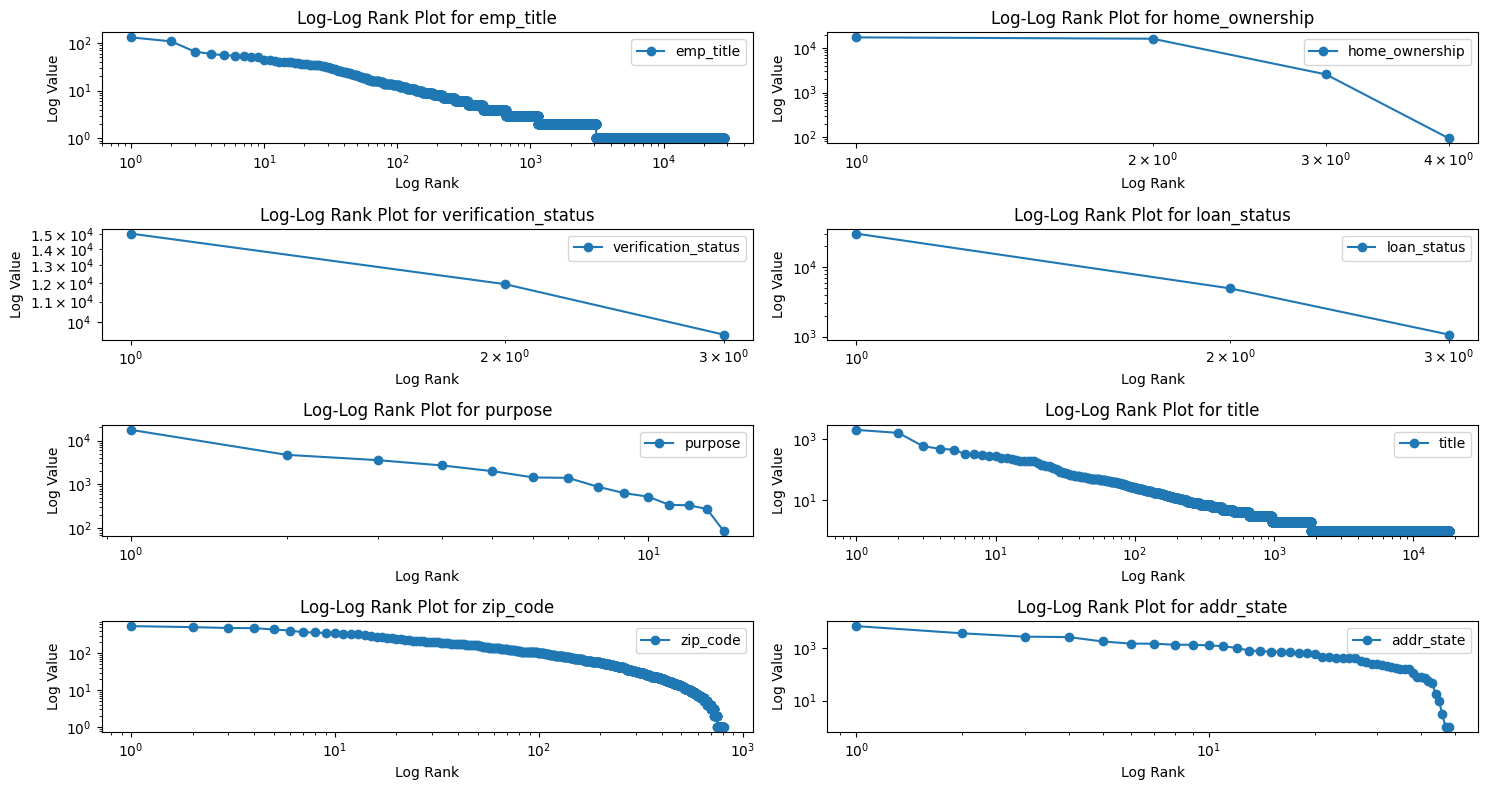

In [159]:
categorical_unordered = ['emp_title', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state']
nrows = math.ceil(len(categorical_unordered) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 8))
for i, column in enumerate(categorical_unordered):
    # Rank Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sorted_values = df_loan[column].value_counts().sort_values(ascending=False)
    ranks = range(1, len(sorted_values) + 1)
    axes[row, col].loglog(ranks, sorted_values, marker='o', linestyle='-', label=f'{column}')
    axes[row, col].set_title(f'Log-Log Rank Plot for {column}')
    axes[row, col].set_xlabel('Log Rank')
    axes[row, col].set_ylabel('Log Value')
    axes[row, col].legend()

# Remove empty subplots if the grid has more cells than needed
for j in range(len(categorical_unordered), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### From the above rank log-log plot, it can be concluded that except in certain part of plot, all categorical unordered variables are following power distribution law.

#### Univariate Analysis for Categorical Ordered Variable

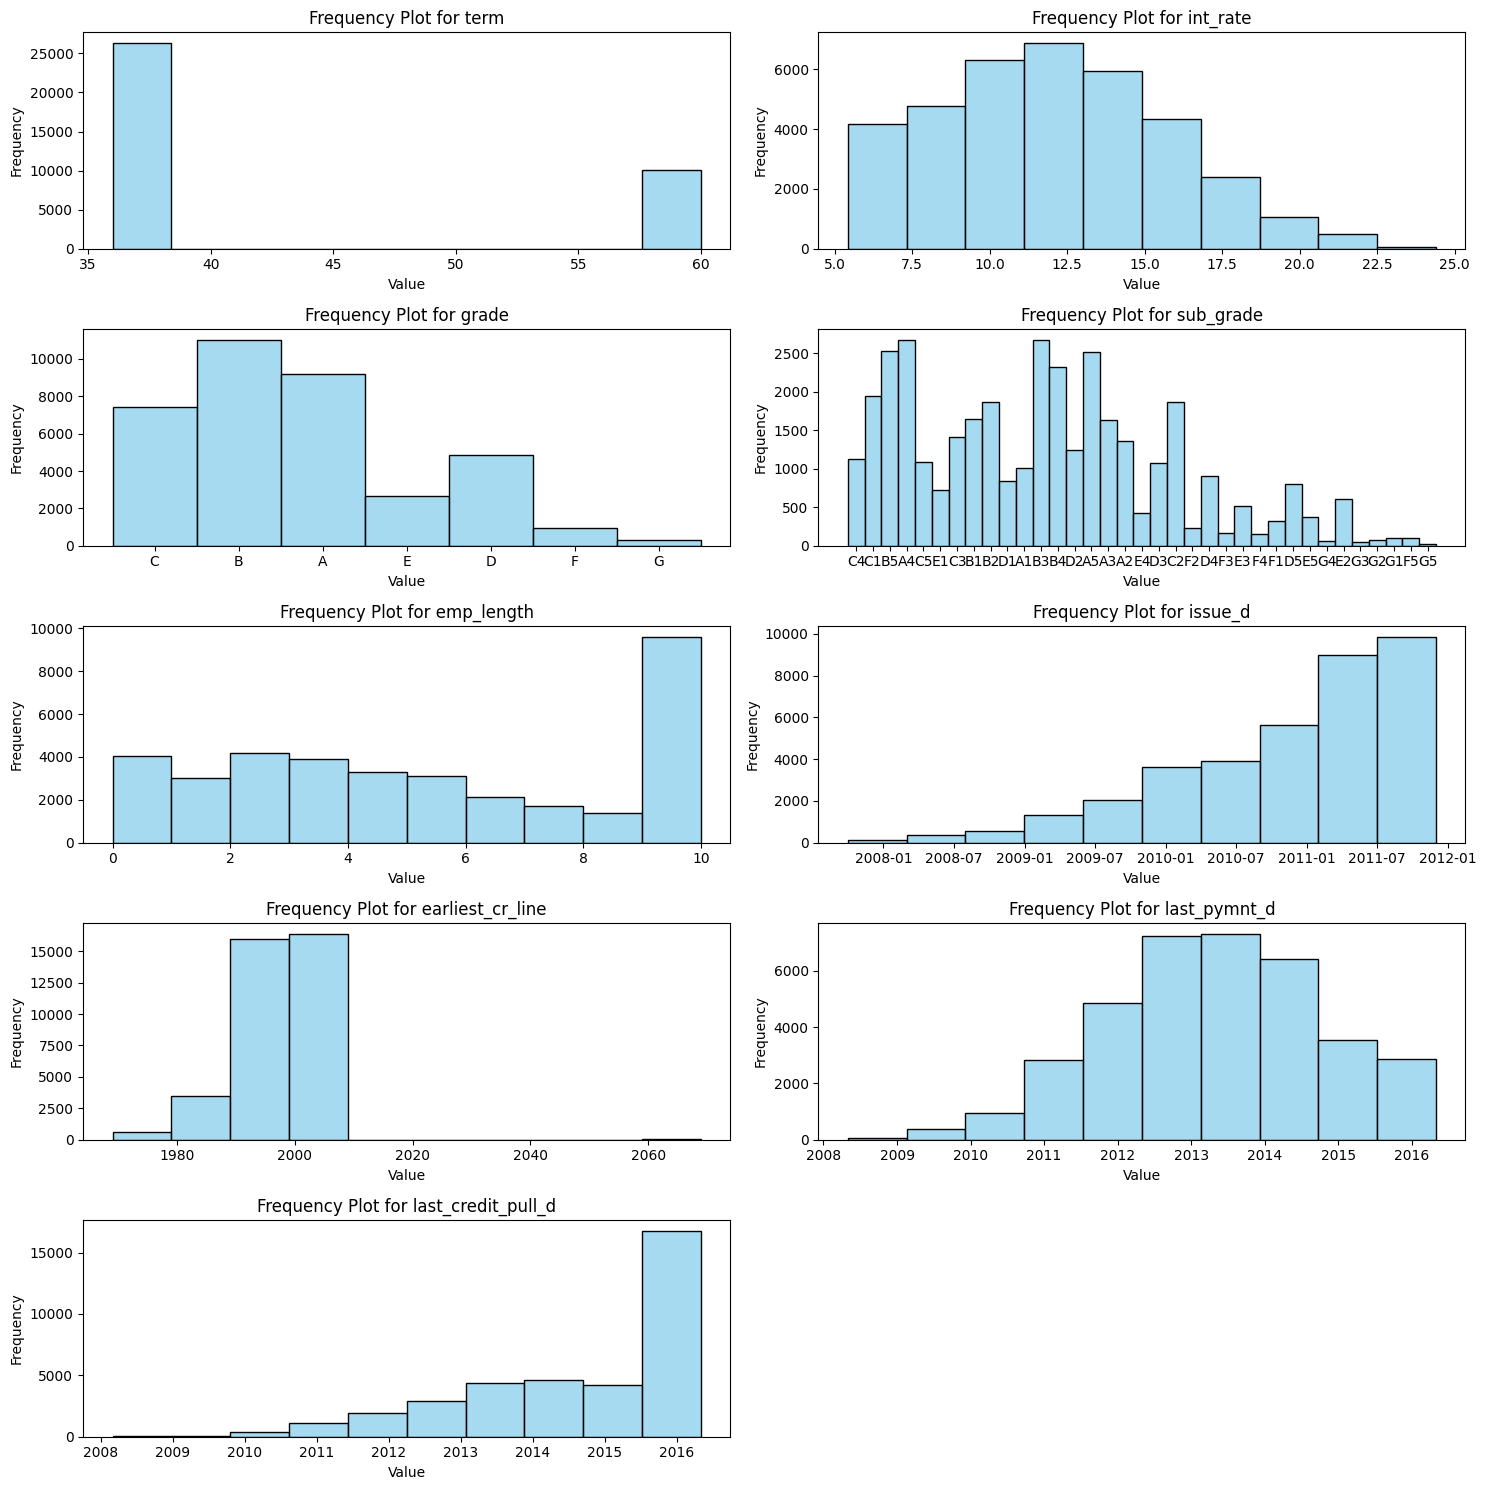

In [160]:
categorical_ordered = ['term', 'int_rate', 'grade', 'sub_grade', 'emp_length', 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
nrows = math.ceil(len(categorical_ordered) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 15))
for i, column in enumerate(categorical_ordered):
    # Frequency Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sns.histplot(df_loan[column], bins=10, kde=False, ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Frequency Plot for {column}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Remove empty subplots if the grid has more cells than needed
for j in range(len(categorical_ordered), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### Insights that we can come up from above histogram:
- <b>Term plot(term)</b>: Maximum loans are duration of 3 years. Low duration mean low risk of default. Bank can approach to those customers who have either fully paid their loan or near the end of loan duration.
- <b>Interest Rate plot(int_rate)</b>: Maximum loans lies in intereset rate range 9 - 15%. It should be analyzed to what kind of customers interst rate lower than 9 or higher than 15 is offered. Instead of 9 or 15 we can consider quartile 1 and quartile 3 for comparison. May be higher interest rate was offered to customer having bad track record and lower interest rate to customers having good track record.
- <b>Grade plot(grade)</b>: Most of the A or B grade customers are assigned loan. This shows that bank is interested in alloting loans to only those customers having very low risk. It could be further analyzed that what common in customers having grade higher than B (C, D, E, F, or G) due to which bank provided them loan and can they be risk for further loans.
- <b>Sub-grade plot(sub_grade)</b>: As we can see that A4, B5 are alloted loan in large number than A1. One hypothesis is that out of all the customers applying for loan in bank, very few are of A1 as compare to A4, B5. Otherwise based on grade analysis bank would not reject A1 applications.
- <b>Employee Length(emp_length)</b>: Bank is preferring those customers more who have high employee length. However there are also customers which have low employee length. These customers could be potential risk for bank for current and future loans.
- <b>Issue Date(issue_d)</b>: With time loan applications are increasing. This could be due to various factors like economic conditions, bank policies, or changes in lending practices.
- <b>Earliest Credit Lines(earliest_cr_line)</b>: Most of the customers has credit history between 1990 to 2010. Customer with oldest credit history are more reliable. There is <u>INVALID</u> data as well. earliest_cr_line greater than 2025 is not possible in data.
- <b>Last Payment Date(last_pymnt_d)</b>: Most of the payments done between 2012-2015. After than reduction in payments can indicate either settled loans, default loans or unavailable data.
- <b>Last Credit Pull (last_credit_pull_d)</b>: After 2015, credit report is frequently pulled

In [161]:
# Removing invalid value from earliest_cr_line
current_year = datetime.datetime.now().year #get current year
print("Shape before removing rows {0}".format(df_loan.shape))
df_loan = df_loan[df_loan['earliest_cr_line'].dt.year <= current_year]
print("Shape before removing rows {0}".format(df_loan.shape))

Shape before removing rows (36431, 41)
Shape before removing rows (36381, 41)


In [162]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36381 entries, 1 to 39623
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   loan_amnt                36381 non-null  int64         
 1   funded_amnt              36381 non-null  int64         
 2   funded_amnt_inv          36381 non-null  float64       
 3   term                     36381 non-null  int64         
 4   int_rate                 36381 non-null  float64       
 5   installment              36381 non-null  float64       
 6   grade                    36381 non-null  object        
 7   sub_grade                36381 non-null  object        
 8   emp_title                36381 non-null  object        
 9   emp_length               36381 non-null  int64         
 10  home_ownership           36381 non-null  object        
 11  annual_inc               36381 non-null  float64       
 12  verification_status      36381 non-nu

In [164]:
#find segmented univariate of all catgorical variables with loan_status with percentages
def find_segmented_univariate_categorical(df, column, target_column):
    result = df.groupby([column, target_column]).size().unstack()
    result['total'] = result.sum(axis=1)
    result['percentage'] = (result[result.columns[0]] / result['total']) * 100
    return result

for column in categorical_unordered:
    print(find_segmented_univariate_categorical(df_loan, column, 'loan_status')[['Charged Off','total','percentage']].sort_values(by='percentage', ascending=False).head(5))
    print('\n')

for column in categorical_ordered:
    print(find_segmented_univariate_categorical(df_loan, column, 'loan_status')[['Charged Off','total','percentage']].sort_values(by='percentage', ascending=False).head(5))
    print('\n')

loan_status                           Charged Off  total  percentage
emp_title                                                           
(self) Castleforte Group                      1.0    1.0       100.0
Riverside Community College District          2.0    2.0       100.0
Richemont                                     1.0    1.0       100.0
Richfield Management                          1.0    1.0       100.0
Rick Baker Insurance                          1.0    1.0       100.0


loan_status     Charged Off    total  percentage
home_ownership                                  
OTHER                  18.0     93.0   19.354839
RENT                 2516.0  17449.0   14.419164
OWN                   344.0   2567.0   13.400857
MORTGAGE             2055.0  16272.0   12.629056


loan_status          Charged Off  total  percentage
verification_status                                
Verified                    1846  11909   15.500882
Source Verified             1320   9436   13.988978
Not Verifie